In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split

os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [2]:
df = pd.read_excel('mouse_data.xlsx')
df_train = df[df['train_or_test'] == 'train']
df_test = df[df['train_or_test'] == 'test']

In [3]:
train_npy_list = []
valid_npy_list = []

for file_name in df_train['file_name']:
    train_npy_list.append(file_name.split('_', 1)[0] + '.npy')

for file_name in df_test['file_name']:
    valid_npy_list.append(file_name.split('_', 1)[0] + '.npy')

In [4]:
file_dir = '../data/data_1450_1550_5ms'

train_images = np.array([], dtype=np.float32).reshape(0, 250, 250)
train_labels = np.array([], dtype=np.int32)
valid_images = np.array([], dtype=np.float32).reshape(0, 250, 250)
valid_labels = np.array([], dtype=np.int32)

for train_npy in train_npy_list:
    file_path = os.path.join(file_dir, train_npy)
    dict = np.load(file_path, allow_pickle=True).item()
    mean, std = np.mean(dict['images']), np.std(dict['images'])
    dict['images'] = (dict['images'] - mean) / std
    train_images = np.concatenate([train_images, dict['images']], axis=0)
    train_labels = np.concatenate([train_labels, dict['labels']], axis=0)

for valid_npy in valid_npy_list:
    file_path = os.path.join(file_dir, valid_npy)
    dict = np.load(file_path, allow_pickle=True).item()
    mean, std = np.mean(dict['images']), np.std(dict['images'])
    dict['images'] = (dict['images'] - mean) / std
    valid_images = np.concatenate([valid_images, dict['images']], axis=0)
    valid_labels = np.concatenate([valid_labels, dict['labels']], axis=0)

In [5]:
# 创建数据集
class ImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # 处理灰度图通道（转为三通道）
        if image.ndim == 2:  # 单通道灰度图（H, W）
            # 转为三通道（H, W, 3），适应三通道输入模型
            image = np.stack([image] * 3, axis=-1)

        if self.transform:
            image = self.transform(image)

        return image, label

train_transform = transforms.Compose([
    transforms.ToTensor(),
    torchvision.transforms.RandomResizedCrop(224),
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomVerticalFlip(p=0.5),
])

valid_transform = transforms.Compose([
    transforms.ToTensor(),
    torchvision.transforms.CenterCrop(224),
])

train_test_dataset = ImageDataset(train_images, train_labels, transform=train_transform)
valid_dataset = ImageDataset(valid_images, valid_labels, transform=valid_transform)

In [6]:
# 随机划分训练集和测试集
train_size = int(0.7 * len(train_test_dataset) / 100) * 100
test_size = len(train_test_dataset) - train_size
train_dataset, test_dataset = random_split(train_test_dataset, [train_size, test_size])
print(len(train_dataset), len(test_dataset), len(valid_dataset))

5400 2400 2800


In [7]:
# 创建数据加载器
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [8]:
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.models import vit_b_16, ViT_B_16_Weights

# 清理GPU缓存
torch.cuda.empty_cache()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# weights = ResNet18_Weights.DEFAULT
# net = resnet18(weights=weights).to(device)
# net.fc = nn.Linear(net.fc.in_features, 2).to(device)
# nn.init.xavier_uniform_(net.fc.weight)

weights = ViT_B_16_Weights.IMAGENET1K_V1
net = vit_b_16(weights=weights).to(device)
net.heads.head = nn.Linear(in_features=768, out_features=2, bias=True).to(device)
nn.init.xavier_uniform_(net.heads.head.weight)

print(net)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [9]:
# 测试
for images, labels in train_loader:
    images = images.to(device)
    out = net(images)
    print(out.shape)
    break

torch.Size([32, 2])


In [10]:
criterion = nn.CrossEntropyLoss()
# params_1x = [param for name, param in net.named_parameters()
#              if name not in ["fc.weight", "fc.bias"]]
# optimizer = torch.optim.Adam([{'params': params_1x},
#                               {'params': net.fc.parameters(),
#                                'lr': 5e-4},],
#                              lr=5e-5, weight_decay=0.001)

params_1x = [param for name, param in net.named_parameters()
             if name not in ["heads.head.weight", "heads.head.bias"]]
optimizer = torch.optim.Adam([{'params': params_1x},
                              {'params': net.heads.head.parameters(),
                               'lr': 5e-4},],
                             lr=5e-5, weight_decay=0.001)

In [11]:
import time

history = {
    'Epoch': [],
    'Train Loss': [],
    'Test Accuracy': [],
    'Valid Accuracy': [],
}

num_epochs = 30
best_acc = 0
for epoch in range(num_epochs):
    time_start = time.time()
    net.train()
    # 训练数据集
    train_loss = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    # 测试集
    net.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        time_end = time.time() - time_start

        test_acc = correct / total
        print(f"Epoch {epoch + 1:02d}: "
              f"Train Loss    : {train_loss:6.3f}, "
              f"Time of train and test: {time_end:.2f}s")
        print(f"===== ==: Test  Accuracy: "
              f"{test_acc * 100:.2f}%,")

        history['Epoch'].append(epoch + 1)
        history['Train Loss'].append(train_loss)
        history['Test Accuracy'].append(test_acc * 100)

    # 验证集
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        valid_acc = correct / total
        print(f"===== ==: Valid Accuracy: "
              f"{valid_acc * 100:.2f}%, ")
        print("=" * 80)

        history['Valid Accuracy'].append(valid_acc * 100)

    if (test_acc + valid_acc) > best_acc:
        best_acc = test_acc + valid_acc
        torch.save(net.state_dict(), 'model/ViTB16.pth')

print(f'Best Accuracy: ' f'{best_acc * 100:.2f}%')

Epoch 01: Train Loss    : 41.108, Time of train and test: 70.35s
===== ==: Test  Accuracy: 90.50%,
===== ==: Valid Accuracy: 89.21%, 
Epoch 02: Train Loss    : 23.613, Time of train and test: 74.53s
===== ==: Test  Accuracy: 93.58%,
===== ==: Valid Accuracy: 95.64%, 
Epoch 03: Train Loss    : 20.881, Time of train and test: 73.42s
===== ==: Test  Accuracy: 93.92%,
===== ==: Valid Accuracy: 90.71%, 
Epoch 04: Train Loss    : 20.780, Time of train and test: 72.89s
===== ==: Test  Accuracy: 94.46%,
===== ==: Valid Accuracy: 96.21%, 
Epoch 05: Train Loss    : 18.095, Time of train and test: 72.54s
===== ==: Test  Accuracy: 94.67%,
===== ==: Valid Accuracy: 94.82%, 
Epoch 06: Train Loss    : 18.629, Time of train and test: 72.54s
===== ==: Test  Accuracy: 96.17%,
===== ==: Valid Accuracy: 93.82%, 
Epoch 07: Train Loss    : 19.674, Time of train and test: 72.49s
===== ==: Test  Accuracy: 95.75%,
===== ==: Valid Accuracy: 95.61%, 
Epoch 08: Train Loss    : 17.835, Time of train and test: 72.3

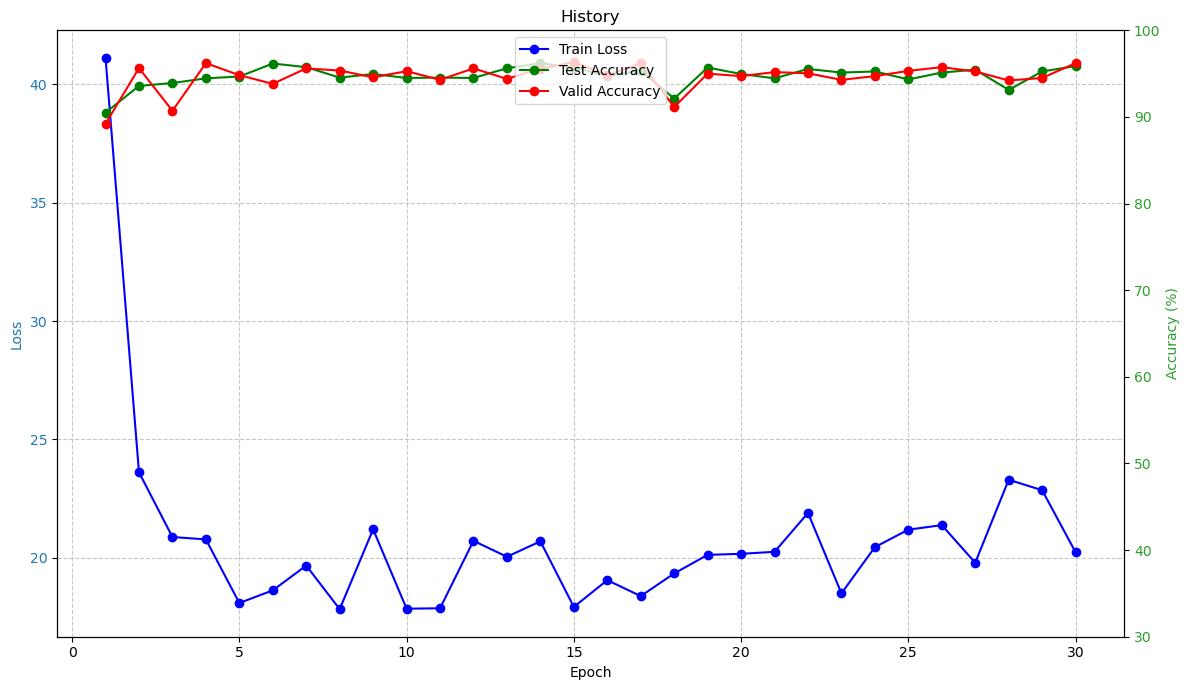

In [15]:
# 创建图形和主坐标轴(左侧纵轴对应损失)
fig, ax1 = plt.subplots(figsize=(12, 7))

# 绘制训练损失曲线(左侧纵轴)
color = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)

ax1.plot(history['Epoch'], history['Train Loss'], 'b-o', label='Train Loss')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, linestyle='--', alpha=0.7)

# 创建共享x轴的次坐标轴(右侧纵轴对应准确率)
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Accuracy (%)', color=color)
ax2.set_ylim([30, 100])

# 绘制准确率曲线(右侧纵轴)
ax2.plot(history['Epoch'], history['Test Accuracy'], 'g-o', label='Test Accuracy')
ax2.plot(history['Epoch'], history['Valid Accuracy'], 'r-o', label='Valid Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

# 添加标题
plt.title('History')

# 合并两个坐标轴的图例
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper center')

# 调整布局
plt.tight_layout()

# 显示图形
plt.show()

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
TestNet = vit_b_16().to(device)
TestNet.heads.head = nn.Linear(in_features=768, out_features=2, bias=True).to(device)
TestNet.load_state_dict(torch.load('model/ViTB16.pth'))

<All keys matched successfully>

In [14]:
def find_transitions(tensor):
    if tensor.numel() == 0:
        return []

    tensor = tensor.flatten()
    elements = tensor.tolist()

    if all(x == 0 for x in elements) or all(x == 1 for x in elements):
        return []

    transitions = []
    prev = elements[0]

    for i in range(1, len(elements)):
        current = elements[i]
        if current != prev:
            if 3 < i < 16:
                transitions.append(i)
            prev = current

    return transitions

num_valid = 2
file_path = os.path.join(file_dir, train_npy_list[num_valid])
print(file_path)
dict = np.load(file_path, allow_pickle=True).item()
images_valid = dict['images']
images_valid = images_valid.reshape(-1, 20, 250, 250)
print(images_valid.shape)

mean = np.mean(images_valid)
std = np.std(images_valid)
images_valid = (images_valid - mean) / std

start = time.time()

with torch.no_grad():
    results = []
    for i in range(images_valid.shape[0]):
        test_imgs = []
        for j in range(20):
            test_img = np.stack([images_valid[i][j]] * 3, axis=-1)
            test_img = valid_transform(test_img)
            test_imgs.append(test_img)
        test_imgs = torch.stack(test_imgs).to(device)
        test_output = TestNet(test_imgs)
        # test_output = net(test_imgs)
        _, predicted = torch.max(test_output, 1)
        results.append(find_transitions(predicted))

print(results)

end = time.time()
print(end - start)

flatten = []
for result in results:
    if len(result) == 1:
        flatten.extend(result * 3)  # 添加三次
    else:
        flatten.extend(result)  # 直接添加所有元素

print(f"SOS Index Mean: {np.mean(flatten):.4f}")
print(f"SOS Index Std : {np.std(flatten):.4f}")
print(f"SOS Prediction: {np.mean(flatten) * 5 + 1450:.4f}")

C:/Users/zhangtw/Desktop/mouse_data/data_1450_1550_5ms\20240606154106.npy
(10, 20, 250, 250)
[[6], [4, 5, 6], [6], [5], [6], [6], [6], [7], [6], [6]]
1.057898759841919
SOS Index Mean: 5.9000
SOS Index Std : 0.5972
SOS Prediction: 1479.5000
